1. Setup MarioAI

In [2]:
# !pip install gym_super_mario_bros nes-py

In [3]:
# import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
#import the game 
import gym_super_mario_bros

# import the symplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# import numpy as np


In [4]:
# fix for latter error where seed is not defined
JoypadSpace.reset = lambda self, **kwargs: self.env.reset(**kwargs)


In [5]:
SIMPLE_MOVEMENT



[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

7 action the AI can make.

In [6]:
# Setup game
env = gym_super_mario_bros.make(
    'SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)


c:\Users\sami\anaconda3\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\sami\anaconda3\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [7]:
# Create a flag - restart or not
done = True
# loop through each frame in game
for step in range (500):
    if done:
        # start the game
        env.reset()
        
    # does random actions
    state, reward, done, info,_ = env.step(env.action_space.sample())
    # render the game / show the game
    env.render()
#close the game
env.close()

c:\Users\sami\anaconda3\lib\site-packages\pyglet\image\codecs\wic.py:289: UserWarning: [WinError -2147417850] Cannot change thread mode after it is set
  warnings.warn(str(err))
c:\Users\sami\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\sami\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
c:\Users\sami\anaconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256



bounding frame of the game 240x256 pixels



 info returned from game environment
env.step(1)[4]

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 40,
 'x_pos_screen': 40,
 'y_pos': 79}


2. Preprocess the Environment

In [46]:
#  !pip install stable_baselines3

# install pytorch
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install stable_baselines3[extra]

In [47]:
# Import Frame stacker Warpperr and GreyScaling Warpper to help with the training

from gym.wrappers import GrayScaleObservation
#import Vectorize warpper 
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack  

#import Matplotlib
from matplotlib import pyplot as plt

In [48]:
# Create Base Environment
# 1. Create the environment
env = gym_super_mario_bros.make(
    'SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
# 2. simplifity the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. apply greyscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside dummy enviroment
env = DummyVecEnv([lambda: env])
# 5. Stack frames
env = VecFrameStack(env, 4, channels_order='last')

c:\Users\sami\anaconda3\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\sami\anaconda3\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
c:\Users\sami\anaconda3\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Reasons for Grayscale are the redused prosseing power required to train the model.
(240, 256, 3) -> Colour image
(240, 256, 1) -> Grayscale image

240x256x1 = 61440 pixels
240x256x3 = 184320 pixels

thus a substantial reduction in the number of pixels to process.

In [11]:
state = env.reset()


In [29]:
state, reward, done, info = env.step([env.action_space.sample()])


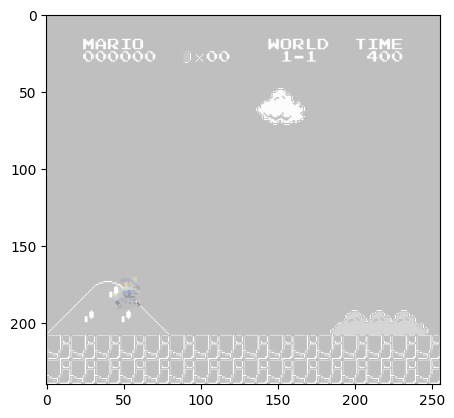

In [30]:
# use matplotlib to show the game frame
plt.imshow(state[0])

<function matplotlib.pyplot.show(close=None, block=None)>

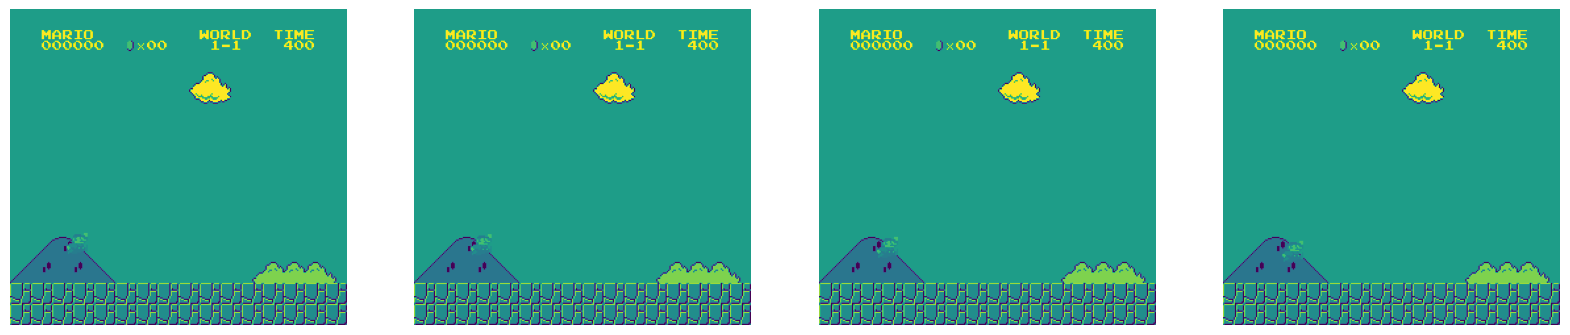

In [31]:
plt.figure(figsize=(20, 16))
for idx in range(state.shape[3]):
    plt.subplot(1, 4, idx + 1)
    plt.imshow(state[0][:, :, idx])
    plt.axis('off')
plt.show

3. Train RL Model

In [49]:
# Improt os for file path mangament
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback



In [50]:
class TrainAndLogginCallback(BaseCallback):
    
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLogginCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [51]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [52]:
# Setup model saving callback
callback = TrainAndLogginCallback(check_freq=10000, save_path=CHECKPOINT_DIR)


In [54]:
# ML model
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001,
            n_steps=512)

Using cpu device
Wrapping the env in a VecTransposeImage.


In [55]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/PPO_1


c:\Users\sami\anaconda3\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\sami\anaconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 92  |
|    iterations      | 1   |
|    time_elapsed    | 5   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 25           |
|    iterations           | 2            |
|    time_elapsed         | 40           |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 4.390988e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.95        |
|    explained_variance   | 0.00359      |
|    learning_rate        | 1e-06        |
|    loss                 | 115          |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00027     |
|    value_loss           | 335          |
------------------------------------------
-----------------------

4. Test RL Model

In [ ]:
#load model
model = PPO.load('./train/best_model_200000', env=env)

In [ ]:
state = env.reset()
while True:
    action, state = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()